## Wind power, wind energy infrastructure and flying fauna overlap analyses in Latin America and the Caribbean
Coded by Nicolás Lois (latest version August 2023).

This python notebook is presented as supporting material for the article submitted to Proceedings of the Royal Society B entitled "Wind energy development in the Neotropics: Risk assessment for flying vertebrates" and authored by Rebolo-Ifrán, Lois and Lambertucci.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.transform import from_bounds
import pandas as pd
import geopandas as gpd
# import regionmask
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# load some spatial processing functions

def rasterize_shp(file, lons, lats):
    sf = gpd.read_file(file)
    sf1 = sf[sf.PRESENCE==1] #filtro por presencia
    sf4 = sf[sf.PRESENCE==4]
    sf = pd.concat([sf1, sf4])
    mask = regionmask.mask_geopandas(sf, lons, lats)
    mask.values[~np.isnan(mask.values)] = 1
    return mask

def reshape_mask_to_matrix(mask, lons, lats, gs_in, gs_out):
    lenlat = len(lats)
    lenlon = len(lons)
    A = mask.values
    nyr = int(lenlat/(gs_out/gs_in))
    nxr = int(lenlon/(gs_out/gs_in))
    B = A.reshape(nyr, int(gs_out/gs_in), nxr, int(gs_out/gs_in))
    C = np.nanmean(B, axis=(1,3))
    return C

def procesamiento_spp(lista_shps):
    list_distrib = []
    list_sp = []
    with open(lista_shps) as f:
        lines = f.readlines()
        lines = [line[:-1] for line in lines]
    for line in lines:
        print(line)
        file = '/home/nicolois/Documents/review_eolicos/shps_database/splitted/'+line+'.shp'
        mask = rasterize_shp(file, lons, lats)
        distrib = reshape_mask_to_matrix(mask, lons, lats, gs_in, gs_out)
        list_distrib.append(distrib)
        list_sp.append(line)
    return list_sp, list_distrib

def sumar_spp_por_pixel(list_distribs, lons, lats, gs_in, gs_out):
    lista = [[],[]]
    lenlat = len(lats)
    lenlon = len(lons)
    nyr = int(lenlat/(gs_out/gs_in))
    nxr = int(lenlon/(gs_out/gs_in))
    spp = np.zeros((nyr, nxr, len(list_distribs)))
    for im in range(len(list_distribs)):
        list_distribs[im] = np.nan_to_num(list_distribs[im])
        spp[:,:,im] = spp[:,:,im] + list_distribs[im]
        cant_spp = np.nansum(spp, axis=2)
    return spp, cant_spp


#### Load, curate and preprocess wind speed and air density datasets
Data downladed from https://globalwindatlas.info/

In [6]:
## Load wind speed and air density datasets
ws = xr.open_rasterio('/home/nicolois/wind_potential/wind-speed_WORLD_50m.tiff')
ad = xr.open_rasterio('/home/nicolois/wind_potential/air-density_WORLD_50m.tiff')

# Overall extent definition
lat_s = -58
lat_n = 34
lon_w = -120
lon_e = -30

# Regrid to 1 degree by 1 degree
tamanio_grilla = 1
coarsen_factor = 400 * tamanio_grilla

data_wind = []
for var in [ws,ad]:
    aver = var.sel(y=slice(lat_n, lat_s)).sel(x=slice(lon_w, lon_e))
    aver.values[aver.values<-990] = np.nan
    aver = np.squeeze(aver.coarsen(x=coarsen_factor, y=coarsen_factor, boundary='trim').mean())
    aver.values[aver.values<0] = np.nan
    aver = aver.sortby(aver.y)
    data_wind.append(aver)

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


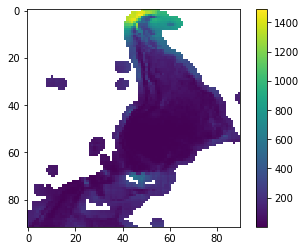

In [7]:
## Calculate and a quick n dirty look at wpd
# WPD(x,y) = 1/2 * AirDens(x,y) * WindSp(x,y)**3
wpd = np.squeeze ( 0.5 * data_wind[1].values * (data_wind[0].values**3) )
plt.imshow(wpd)
plt.colorbar()

In [8]:
wpd.shape

(92, 90)

[-120 -119 -118 -117 -116 -115 -114 -113 -112 -111 -110 -109 -108 -107
 -106 -105 -104 -103 -102 -101 -100  -99  -98  -97  -96  -95  -94  -93
  -92  -91  -90  -89  -88  -87  -86  -85  -84  -83  -82  -81  -80  -79
  -78  -77  -76  -75  -74  -73  -72  -71  -70  -69  -68  -67  -66  -65
  -64  -63  -62  -61  -60  -59  -58  -57  -56  -55  -54  -53  -52  -51
  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39  -38  -37
  -36  -35  -34  -33  -32  -31]
[-58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41
 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23
 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5
  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13
  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
  32  33]


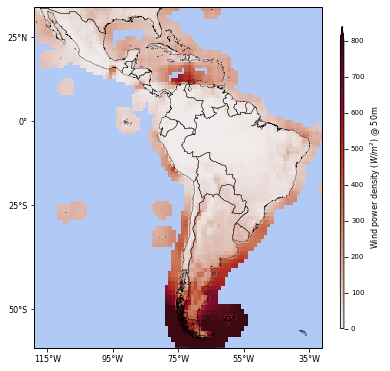

In [9]:
## Simple WPD map
# I use pcolormesh in all maps which plots by default from bottom left
# xr.coarsen also calculates mean of fine vector into the left of coarsened vector
# see help of xr.coarsen a plt.pcolormesh for more details!

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1) 
print(lons)
print(lats)

## plot prueba
position = [0.1, 0.1, 0.8, 0.8]
extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
# yticks = [-55, -45, -35, -25, -15, -5, 5, 15, 25]
yticks = [-50, -25, 0, 25]
fontsize = 8

plt.close('all')
fig = plt.figure(figsize=(5,7))
ax = plt.axes(position, projection=ccrs.Mercator())
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='white', zorder=2)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05, facecolor='cornflowerblue', zorder=2, alpha=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3, facecolor='None', alpha=1, zorder=4)
# ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
#                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
ax.set_aspect('equal', 'box')
ax.outline_patch.set_zorder(5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params('both', labelsize=fontsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
#
wind_plot = ax.pcolormesh(lons, lats, wpd, transform=ccrs.PlateCarree(), vmin=0, vmax=800, cmap=cm.cm.amp, alpha=1, zorder=3)
# wind_plot = ax.contourf(lons, lats, wpd, levels=np.linspace(0, 800, 5), cmap=cm.cm.amp, transform=ccrs.PlateCarree(), alpha=.5, zorder=3, extend='both')
cax = fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(wind_plot ,orientation='vertical', cax=cax, extend='max')
cb.ax.set_ylabel('Wind power density ($ W / m^{2}$) @ 50m',fontsize=8)
# cb.ax.set_yticks([0,10,20,30,40,50])
cb.ax.tick_params(labelsize=7)

# nombre_salida = '/home/nicolois/Documents/review_eolicos/figs/mapa_spp'

# fig.savefig(nombre_salida + '.png', dpi=300, bbox_inches='tight')

In [10]:
# WPD classes applied to WPD matrix

wpd = np.squeeze ( 0.5 * data_wind[1].values * (data_wind[0].values**3) )

wpd_class = wpd.copy()
wpd_class[wpd_class < 50] = 0
wpd_class[(wpd_class >= 50) & (wpd_class < 200)] = 1
wpd_class[(wpd_class >= 200) & (wpd_class < 300)] = 2
wpd_class[(wpd_class >= 300) & (wpd_class < 400)] = 3
wpd_class[(wpd_class >= 400) & (wpd_class < 500)] = 4
wpd_class[(wpd_class >= 500) & (wpd_class < 600)] = 5
wpd_class[(wpd_class >= 600) & (wpd_class < 800)] = 6
wpd_class[(wpd_class >= 800)] = 7

wpd_maps = [wpd,wpd_class]

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered 

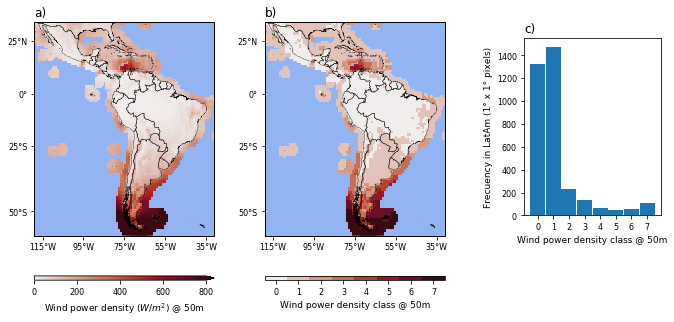

In [11]:
## FIGURE S3 - WPD in Latam and the Caribbean

position = [[0.05, 0.1, 0.25, 0.7], [0.37, 0.1, 0.25, 0.7], [0.73, 0.25, 0.19, 0.41]]
extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1) 

plt.close('all')
fig = plt.figure(figsize=(10,6))

for i in range(len(position)):
    if i==2:
        dim1 = np.reshape(wpd_class,-1)
        bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
        ax = plt.axes(position[i])
        ax.hist(dim1, bins, rwidth=.95)
        ax.set_xticks([0,1,2,3,4,5,6,7])
        ax.tick_params('both', labelsize=fontsize)
        # ax.set_ylim([0,50])
        ax.set_xlabel('Wind power density class @ 50m',fontsize=9)
        ax.set_ylabel('Frecuency in LatAm (1° x 1° pixels)',fontsize=9)
        ax.set_title('c)', loc='left')
    
    else:
        ax = plt.axes(position[i], projection=ccrs.Mercator())
        ax.set_extent(extent, ccrs.PlateCarree())        
        ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                       facecolor='cornflowerblue', zorder=2, alpha=0.7)
        ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                       facecolor='None', alpha=1, zorder=4)
        # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
        #                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
        ax.set_aspect('equal', 'box')
        ax.outline_patch.set_zorder(5)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params('both', labelsize=fontsize)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        # ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)

        if i==0:
            ax.set_title('a)', loc='left')
            wind_plot = ax.pcolormesh(lons, lats, wpd_maps[i], transform=ccrs.PlateCarree(), vmin=0, vmax=800, cmap=cm.cm.amp, alpha=1, zorder=3)
            cax = fig.add_axes([0.05, 0.1, 0.25, 0.01])
            cb = fig.colorbar(wind_plot ,orientation='horizontal', cax=cax, extend='max')
            cb.ax.set_xlabel('Wind power density ($ W / m^{2}$) @ 50m',fontsize=9)
            # cb.ax.set_yticks([0,10,20,30,40,50])
            cb.ax.tick_params('both', labelsize=fontsize)
            
        if i==1:
            ax.set_title('b)', loc='left')
            wind_plot = ax.pcolormesh(lons, lats, wpd_maps[i], transform=ccrs.PlateCarree(), vmin=0, vmax=7, cmap=cm.cm.amp, alpha=1, zorder=3)
            bounds = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
            ticks = [0,1,2,3,4,5,6,7]
            cax = fig.add_axes([0.37, 0.1, 0.25, 0.01])
            cb = fig.colorbar(wind_plot ,orientation='horizontal', cax=cax, boundaries = bounds, ticks = ticks)
            cb.ax.set_xlabel('Wind power density class @ 50m',fontsize=9)
            cb.ax.set_xticklabels([0,1,2,3,4,5,6,7])
            cb.ax.tick_params('both', labelsize=fontsize)

nombre_salida = '/home/nicolois/wind_potential/figs_finales/FigS3_wpd'
fig.savefig(nombre_salida + '.png', dpi=400, bbox_inches='tight')


#### Load birds datasets
Two sources have been compiled, curated and analysed in this article: eBird Citizen Science dataset and IUCN RedList distribution maps.

In order to work within the xarray envivorenment, shapefile distributions are loaded into the 1 by 1 degree grid and saved as a netcdf file for further usage.

In [25]:
## Load distributions in netcdf format, straight
# after running the code it could be run from here , which makes the workflow much faster.
# finally we export the list of spp in each dataset

ds_spp_iucn = xr.open_dataset('/home/nicolois/wind_potential/spp_endangered_birds_iucn_1x1.nc')
ds_spp_ebird = xr.open_dataset('/home/nicolois/wind_potential/spp_endangered_birds_ebird_1x1.nc')

list_spp_iucn = [i for i in ds_spp_iucn.data_vars]
list_spp_ebird = [i for i in ds_spp_ebird.data_vars]

import csv
with open('/home/nicolois/wind_potential/lista_ebird.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for item in list_spp_ebird:
        wr.writerow([item])
    
with open('/home/nicolois/wind_potential/lista_iucn.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    for item in list_spp_iucn:
        wr.writerow([item])
        
len(list_spp_iucn) # should be 489 !!

489

In [70]:
list_spp_ebird = []

with open('birds_sp_396_ebird -6.list', mode='r') as f:
    for lines in f:
        line = lines.rstrip()  # remove the newline character
        list_spp_ebird.append(line)  # add the line in the list

list_spp_ebird


['Accipiter_gundlachi',
 'Acrobatornis_fonsecai',
 'Agelaius_tricolor',
 'Agelaius_xanthomus',
 'Aglaeactis_aliciae',
 'Aglaiocercus_berlepschi',
 'Agriornis_albicauda',
 'Alectrurus_risora',
 'Alectrurus_tricolor',
 'Amazilia_boucardi',
 'Amazilia_luciae',
 'Amazona_agilis',
 'Amazona_arausiaca',
 'Amazona_auropalliata',
 'Amazona_collaria',
 'Amazona_finschi',
 'Amazona_guildingii',
 'Amazona_imperialis',
 'Amazona_oratrix',
 'Amazona_pretrei',
 'Amazona_rhodocorytha',
 'Amazona_tucumana',
 'Amazona_ventralis',
 'Amazona_versicolor',
 'Amazona_vinacea',
 'Amazona_viridigenalis',
 'Ammospiza_caudacuta',
 'Ampelornis_griseiceps',
 'Anairetes_alpinus',
 'Anodorhynchus_hyacinthinus',
 'Anodorhynchus_leari',
 'Anthocephala_berlepschi',
 'Anthocephala_floriceps',
 'Anthus_nattereri',
 'Anthus_spragueii',
 'Antilophia_bokermanni',
 'Antrostomus_noctitherus',
 'Anumara_forbesi',
 'Aphanotriccus_capitalis',
 'Aphelocoma_coerulescens',
 'Aphrastura_masafuerae',
 'Ara_glaucogularis',
 'Ara_mili

In [71]:
len(list_spp_ebird)
# should be 390

390

In [72]:
list_spp_iucn = []

with open('birds_sp_456_iucn.list', mode='r') as f:
    for lines in f:
        line = lines.rstrip()  # remove the newline character
        list_spp_iucn.append(line)  # add the line in the list

list_spp_iucn


['Accipiter_gundlachi',
 'Acrobatornis_fonsecai',
 'Agelaius_tricolor',
 'Agelaius_xanthomus',
 'Aglaeactis_aliciae',
 'Aglaiocercus_berlepschi',
 'Agriornis_albicauda',
 'Alectrurus_risora',
 'Alectrurus_tricolor',
 'Amazilia_alfaroana',
 'Amazilia_boucardi',
 'Amazilia_lilliae',
 'Amazilia_luciae',
 'Amazona_agilis',
 'Amazona_arausiaca',
 'Amazona_auropalliata',
 'Amazona_collaria',
 'Amazona_finschi',
 'Amazona_guildingii',
 'Amazona_imperialis',
 'Amazona_lilacina',
 'Amazona_oratrix',
 'Amazona_pretrei',
 'Amazona_rhodocorytha',
 'Amazona_tucumana',
 'Amazona_ventralis',
 'Amazona_versicolor',
 'Amazona_vinacea',
 'Amazona_viridigenalis',
 'Amazona_vittata',
 'Ammospiza_caudacuta',
 'Ampelornis_griseiceps',
 'Anairetes_alpinus',
 'Anodorhynchus_glaucus',
 'Anodorhynchus_hyacinthinus',
 'Anodorhynchus_leari',
 'Anthocephala_berlepschi',
 'Anthocephala_floriceps',
 'Anthus_nattereri',
 'Anthus_spragueii',
 'Antilophia_bokermanni',
 'Antrostomus_noctitherus',
 'Anumara_forbesi',
 'A

In [73]:
len(list_spp_iucn)
#should be 456

456

In [77]:
shared_species = set(list_spp_iucn).intersection(list_spp_ebird)
shared_species = [i.replace ("_"," ") for i in shared_species]
len(shared_species)

390

In [82]:
# NO ESTA ANDANDO, IMPORTANTE PARA FIG S3 Spatial and quantitative comparison of eBird and IUCN datasets

lenlat2 = len(ds_spp_iucn.lat)
lenlon2 = len(ds_spp_iucn.lon)

fuentes = [ds_spp_ebird, ds_spp_iucn]

mapa_cant_spp_ebird = np.zeros((lenlat2,lenlon2))
mapa_cant_spp_iucn = np.zeros((lenlat2,lenlon2))

shared_species = set(list_spp_iucn).intersection(list_spp_ebird)
shared_species = [i.replace ("_"," ") for i in shared_species]

for i,fuente in enumerate(fuentes):
    for sp in shared_species:
            arr = fuente[sp].values
            arr[arr>0] = 1
            arr[np.isnan(arr)] = 0
            if i==0:
                mapa_cant_spp_ebird = mapa_cant_spp_ebird + arr
            if i==1:
                mapa_cant_spp_iucn = mapa_cant_spp_iucn + arr

# Calcular la diferencia
diff = mapa_cant_spp_iucn - mapa_cant_spp_ebird

# Reemplazar ceros con NaN para las visualizaciones
mapa_cant_spp_ebird[mapa_cant_spp_ebird == 0] = np.nan
mapa_cant_spp_iucn[mapa_cant_spp_iucn == 0] = np.nan

# Crear máscaras para identificar donde hay datos en ambos mapas
mask_ebird = ~np.isnan(mapa_cant_spp_ebird)
mask_iucn = ~np.isnan(mapa_cant_spp_iucn)
mask_both = mask_ebird & mask_iucn

# Aplicar la máscara a la matriz de diferencias
diff[~mask_both] = np.nan

index_cant_spp_ebird = mapa_cant_spp_ebird / np.nanmax(mapa_cant_spp_ebird)
index_cant_spp_iucn = mapa_cant_spp_iucn / np.nanmax(mapa_cant_spp_iucn)

mapa_spp = [mapa_cant_spp_ebird, mapa_cant_spp_iucn, diff]


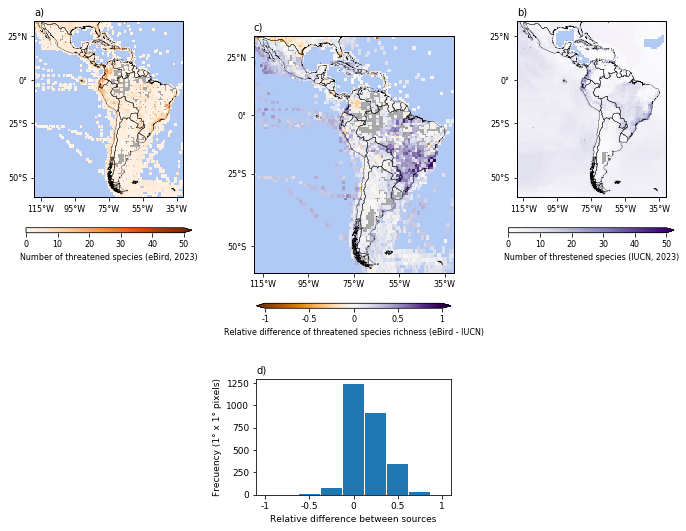

In [86]:
## Figure S1 - Plot IUCN vs eBird

position = [[0.05, 0.6, 0.23, 0.35], [0.72, 0.6, 0.23, 0.35], [0.33, 0.45, 0.35, 0.47],
            [0.37, 0.01, 0.27, 0.23]]

cb_axes =  [[0.05, 0.53, 0.23, 0.01], [0.72, 0.53, 0.23, 0.01], [0.37, 0.38, 0.27, 0.01]]

extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-119,-30,1)
lats = np.arange(-57,34,1) 

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1) 

plt.close('all')
fig = plt.figure(figsize=(10,7))

for i in range(len(position)):
    if i ==3:
        dim1 = np.reshape(diff/np.nanmax(abs(diff)),-1)
        bins = [-.875,-.625,-.375,-.125,.125,.375,.625,.875]
        ax = plt.axes(position[i])
        ax.hist(dim1, bins, rwidth=.95)
        ax.tick_params('both', labelsize=9)
        ax.set_xlim([-1.1,1.1])
        ax.set_xticks([-1,-.5,0,.5,1])
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
        ax.set_xlabel('Relative difference between sources',fontsize=9)
        ax.set_ylabel('Frecuency (1° x 1° pixels)',fontsize=9)
        ax.set_title('d)', loc='left', fontsize=10)
    
    else:
        ax = plt.axes(position[i], projection=ccrs.Mercator())
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                       facecolor='cornflowerblue', zorder=2, alpha=0.5)
        ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                       facecolor='None', alpha=1, zorder=4)
        # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
        #                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
        ax.set_aspect('equal', 'box')
        ax.outline_patch.set_zorder(5)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params('both', labelsize=fontsize)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        # ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
        
        if i == 0:
            spp = ax.pcolormesh(lons, lats, mapa_spp[i], transform=ccrs.PlateCarree(), vmin=0, vmax=50, cmap='Oranges', alpha=1, zorder=3)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
            cb.ax.set_xlabel('Number of threatened species (eBird, 2023)',fontsize=8)
            cb.ax.tick_params(labelsize=8)
            ax.set_title('a)', loc='left', fontsize=10)
            
        if i == 1:
            spp = ax.pcolormesh(lons, lats, mapa_spp[i], transform=ccrs.PlateCarree(), vmin=0, vmax=50, cmap='Purples', alpha=1, zorder=3)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
            cb.ax.set_xlabel('Number of threstened species (IUCN, 2023)',fontsize=8)
            cb.ax.tick_params(labelsize=8)
            ax.set_title('b)', loc='left', fontsize=10)
                    
        if i == 2:
            spp = ax.pcolormesh(lons, lats, mapa_spp[i]/np.nanmax(mapa_spp[i]), vmin=-1, vmax=1, transform=ccrs.PlateCarree(), cmap='PuOr', alpha=1, zorder=3)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='both', ticks=[-1,-0.5,0,0.5,1])
            cb.ax.set_xlabel('Relative difference of threatened species richness (eBird - IUCN)',fontsize=8)
            cb.ax.set_xticklabels(['-1','-0.5','0','0.5','1'], fontsize=8)
            cb.ax.tick_params(labelsize=8)
            ax.set_title('c)', loc='left', fontsize=10)


nombre_salida = '/home/nicolois/wind_potential/figs_finales/FigS1_IUCN-eBird'
fig.savefig(nombre_salida + '.png', dpi=300, bbox_inches='tight')

In [87]:
### Load IUCN bat dataset following same strategy as for birds.

ds_spp_murcis = xr.open_dataset('/home/nicolois/wind_potential/spp_endangered_murcis_1x1.nc')
list_spp_murcis = [i for i in ds_spp_murcis.data_vars]

lenlat2 = len(ds_spp_murcis.lat)
lenlon2 = len(ds_spp_murcis.lon)

mapa_cant_spp_murcis = np.zeros((lenlat2,lenlon2))

for sp in list_spp_murcis:
    arr = ds_spp_murcis[sp].values
    arr[arr>0] = 1
    arr[np.isnan(arr)] = 0
    mapa_cant_spp_murcis = mapa_cant_spp_murcis + arr

index_cant_spp_murcis = mapa_cant_spp_murcis / np.nanmax(mapa_cant_spp_murcis)
index_cant_spp_murcis[index_cant_spp_murcis==0] = np.nan
mapa_cant_spp_murcis[mapa_cant_spp_murcis==0] = np.nan

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


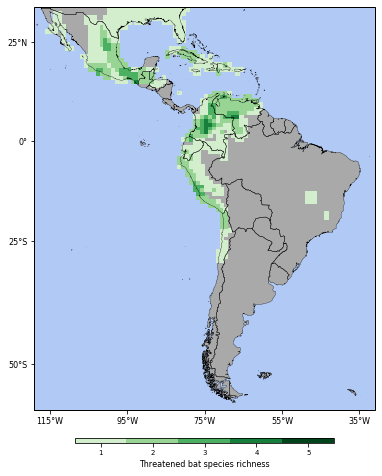

In [88]:
## Mapping threatened bats in LatAm and the Caribbean

position = [0.1, 0.1, 0.8, 0.8]
extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons2 = np.arange(-120,-30,1)
lats2 = np.arange(-58,34,1) 

plt.close('all')
fig = plt.figure(figsize=(6,7))
ax = plt.axes(position, projection=ccrs.Mercator())
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                facecolor='cornflowerblue', zorder=2, alpha=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                facecolor='None', alpha=1, zorder=4)
# ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
#                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
ax.set_aspect('equal', 'box')
ax.outline_patch.set_zorder(5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params('both', labelsize=fontsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
wind_superpos = ax.pcolormesh(lons2, lats2, mapa_cant_spp_murcis, transform=ccrs.PlateCarree(),
                              vmin=0, vmax=5, cmap='Greens', alpha=1, zorder=3)
# wind_potential = ax.pcolormesh(lons, lats, index_wpd, transform=ccrs.PlateCarree(), vmin=0,  cmap='Reds', alpha=1, zorder=3)
# ax.plot(data['lon'],data['lat'], transform=ccrs.PlateCarree(), c= 'k', lw=0, marker='.', ms=3, zorder=15, label='Wind farm')
# ax.legend(loc='lower left')

# ax.plot([-77,-57,-57,-77,-77], [-55,-55,-43,-43,-55], transform=ccrs.PlateCarree(), 
#          c="k", alpha=.8, lw=2, ls='solid', zorder=10, label='Patagonia')

# ax.plot([-73,-51,-51,-73,-73], [-37,-37,-37+18,-37+18,-37], transform=ccrs.PlateCarree(), 
#          c="k", alpha=.8, lw=2,ls='dashed', zorder=10, label='Center SAm')

# ax.plot([-95,-59,-59,-95,-95], [9,9,27,27,9], transform=ccrs.PlateCarree(), 
#          c="k", alpha=.8, lw=2, ls='dotted', zorder=10, label='Caribbean')

# ax.legend(loc='lower left',fontsize=9)
cax = fig.add_axes([0.2, 0.035, 0.6, 0.01])
cb = fig.colorbar(wind_superpos,orientation='horizontal', cax=cax,
                  boundaries=[0.5,1.5,2.5,3.5,4.5,5.5], ticks=[1,2,3,4,5])
cb.ax.set_xlabel('Threatened bat species richness',fontsize=8)
cb.ax.tick_params(labelsize=7)

# fig.savefig('/home/nicolois/wind_potential/figs/10_mapa_bat_richness.png', dpi=600, bbox_inches='tight')

#### Load wind energy infrastruture data from review

In [89]:
## Load wind turbines dataset
# Two datasets generated - wind turbines and wind facilities
# (some wind facilities operators do not provide turbine number)

# Wind turbines #
lons2 = np.arange(-120,-30,1)
lats2 = np.arange(-58,34,1)
lenlat2 = len(lats2)
lenlon2 = len(lons2)
shape2 = (lenlat2,lenlon2)

data_csv = '/home/nicolois/wind_potential/Eolicos_Latam_Database.csv'
data = pd.read_csv(data_csv, encoding='latin-1')

data['lon'] = data.lon.astype('float')
data['lat'] = data.lat.astype('float')

m    = np.zeros((lenlat2,lenlon2))
m[:] = np.nan

for ilon in range(lenlon2-1):
    lon0 = lons2[ilon]
    lon1 = lons2[ilon+1]
    for ilat in range(lenlat2-1):
        lat0 = lats2[ilat]
        lat1 = lats2[ilat+1]
        # print(lon0,lat0)

        df  = data.loc[data['lon'] > lon0]
        df2 = df.loc[df['lat'] > lat0]
        df3 = df2.loc[df2['lon'] < lon1]
        df4 = df3.loc[df3['lat'] < lat1]

        if int(df4['aerogeneradores'].count()) == 0:
             m[ilat,ilon] = np.nan

        else:
            m[ilat,ilon] = int(df4['aerogeneradores'].sum())
            

# Wind facilities #
m_all    = np.zeros((lenlat2,lenlon2))
m_all[:] = np.nan

for ilon in range(lenlon2-1):
    lon0 = lons2[ilon]
    lon1 = lons2[ilon+1]
    for ilat in range(lenlat2-1):
        lat0 = lats2[ilat]
        lat1 = lats2[ilat+1]
        # print(lon0,lat0)

        df  = data.loc[data['lon'] > lon0]
        df2 = df.loc[df['lat'] > lat0]
        df3 = df2.loc[df2['lon'] < lon1]
        df4 = df3.loc[df3['lat'] < lat1]

        if int(df4['nombre'].count()) == 0:
             m_all[ilat,ilon] = np.nan

        else:
            m_all[ilat,ilon] = int(df4['nombre'].count())

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


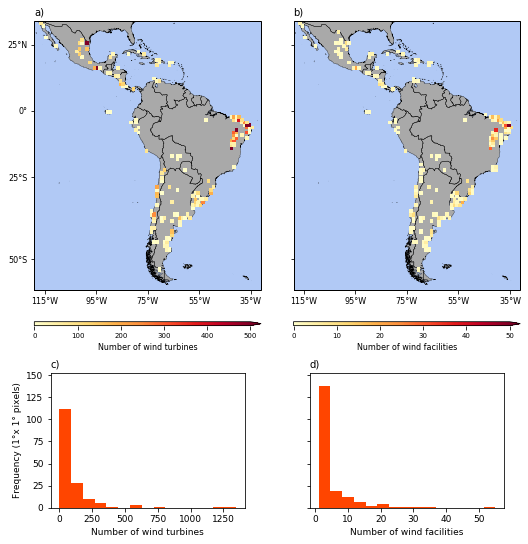

In [90]:
## Figure 3 - Wind facilities density in LatAm and Caribbean 

position = [ [0.1, 0.5, 0.35, 0.45 ], [0.5, 0.5, 0.35, 0.45 ],
             [0.125, 0.28, 0.3, 0.17], [0.525, 0.28, 0.3, 0.17]  ]

cb_axes =  [[0.1, 0.51, 0.35, 0.005], [0.5, 0.51, 0.35, 0.005]]

extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1) 

titulo_barra = ['Número de aerogeneradores', 'Número de establecimientos']
figname = ['04_aerogeneradores', '04bis_establecimientos']
matrices = [m, m_all]

plt.close('all')
fig = plt.figure(figsize=(9,11))


for i in range(len(position)):
    
    if i > 1:
        dim1 = np.reshape(matrices[i-2],-1)
        bins = 15
        ax = plt.axes(position[i])
        ax.hist(dim1, bins, color='orangered')
        ax.tick_params('both', labelsize=9)
        ax.set_ylim([0,152])
        
        if i == 2:
            ax.set_title('c)', loc="left", fontsize=10)
            # ax.set_xlim([-1.1,1.1])
            # ax.set_xticks([-1,-.5,0,.5,1])
            # ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
            ax.set_xlabel('Number of wind turbines',fontsize=9)
            ax.set_ylabel('Frequency (1°x 1° pixels)',fontsize=9)
            
        else:
            ax.set_yticklabels([])
            ax.set_title('d)', loc='left', fontsize=10)
            # ax.set_xlim([-1.1,1.1])
            # ax.set_xticks([-1,-.5,0,.5,1])
            # ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
            ax.set_xlabel('Number of wind facilities',fontsize=9)
            
    if i < 2:
        ax = plt.axes(position[i], projection=ccrs.Mercator())
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                       facecolor='cornflowerblue', zorder=2, alpha=0.5)
        ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                       facecolor='None', alpha=1, zorder=9)
        # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
        #                                    facecolor=cfeature.COLORS['land'], lw=0.1, alpha=0.5, zorder=10)
        ax.set_aspect('equal', 'box')
        ax.outline_patch.set_zorder(15)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params('both', labelsize=fontsize)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        
        # ax.plot(data['lon'],data['lat'], transform=ccrs.PlateCarree(), c= 'k', lw=0, marker='.', ms=3, zorder=15, label='Wind farm')
        # ax.legend(loc='lower left')
        
        if i==0:
            
            eolico = ax.pcolormesh(lons, lats, matrices[i], transform=ccrs.PlateCarree(), vmin=0, vmax=500, cmap='YlOrRd', alpha=1, zorder=10)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(eolico ,orientation='horizontal',cax=cax, extend='max')
            cb.ax.set_xlabel('Number of wind turbines',fontsize=8)
            # cb.ax.set_yticks([0,10,20,30,40,50])
            cb.ax.tick_params(labelsize=7)
            ax.set_title('a)', loc="left", fontsize=10)
        
        else:
            ax.set_yticklabels([])
            eolico = ax.pcolormesh(lons, lats, matrices[i], transform=ccrs.PlateCarree(), vmin=0, vmax=50, cmap='YlOrRd', alpha=1, zorder=10)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(eolico ,orientation='horizontal',cax=cax, extend='max')
            cb.ax.set_xlabel('Number of wind facilities',fontsize=8)
            cb.ax.tick_params(labelsize=7)
            ax.set_title('b)', loc="left", fontsize=10)


nombre_salida = '/home/nicolois/wind_potential/figs_finales/Fig3_WindFacilities'
fig.savefig(nombre_salida + '.png', dpi=600, bbox_inches='tight')
# fig.savefig(nombre_salida + '.pdf', dpi=600, bbox_inches='tight')


#### Overlap analyses
After loading and curating all datasets, overlap analyses are performed:
- Flying fauna + wind energy infrastructure
- Flying fauna + wind power density
- Wind energy infrastructure + wind power density


In [91]:
## Bats + wind enery infrastructure overlap

m_superpos = m.copy()
m_superpos

m_superpos[  m_superpos < 50  ] = 1
m_superpos[(m_superpos >= 50 ) & (m_superpos < 100)] = 2
m_superpos[(m_superpos >= 100) & (m_superpos < 200)] = 3
m_superpos[(m_superpos >= 200) & (m_superpos < 300)] = 4
m_superpos[(m_superpos >= 300) & (m_superpos < 400)] = 5
m_superpos[(m_superpos >= 400) & (m_superpos < 500)] = 6
m_superpos[(m_superpos >= 500)] = 7
index_m_superpos = m_superpos/np.nanmax(m_superpos)
superpos_spp_aerogen = index_m_superpos * index_cant_spp_murcis

m_all_superpos = m_all.copy()
m_all_superpos

m_all_superpos[  m_all_superpos < 50  ] = 1
m_all_superpos[(m_all_superpos >= 50 ) & (m_all_superpos < 100)] = 2
m_all_superpos[(m_all_superpos >= 100) & (m_all_superpos < 200)] = 3
m_all_superpos[(m_all_superpos >= 200) & (m_all_superpos < 300)] = 4
m_all_superpos[(m_all_superpos >= 300) & (m_all_superpos < 400)] = 5
m_all_superpos[(m_all_superpos >= 400) & (m_all_superpos < 500)] = 6
m_all_superpos[(m_all_superpos >= 500)] = 7
index_m_all_superpos = m_all_superpos/np.nanmax(m_all_superpos)
superpos_spp_facilit = index_m_all_superpos * index_cant_spp_murcis

superpos95 = m.copy()
superpos95 [:] = np.nan
superpos95 [superpos_spp_aerogen/np.nanmax(superpos_spp_aerogen) > .95] = 1

windfarm95 = m.copy()
windfarm95 [:] = np.nan
windfarm95[index_m_superpos > .95] = 1


/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered 

In [93]:
## Birds + wind enery infrastructure overlap

iucn_spp = pd.read_csv("birds_sp_456_iucn.list", header=None)[0].values.tolist()
iucn_spp = [i.replace("_", " ") for i in iucn_spp]

lenlat2 = len(ds_spp_iucn.lat)
lenlon2 = len(ds_spp_iucn.lon)

mapa_cant_spp_iucn = np.zeros((lenlat2,lenlon2))

for sp in iucn_spp:
    arr = ds_spp_iucn[sp].values
    arr[arr>0] = 1
    arr[np.isnan(arr)] = 0
    mapa_cant_spp_iucn = mapa_cant_spp_iucn + arr

mapa_cant_spp_iucn[mapa_cant_spp_iucn == 0] = np.nan

index_cant_spp_iucn = mapa_cant_spp_iucn / np.nanmax(mapa_cant_spp_iucn)



In [94]:
## Birds + wind enery infrastructure overlap

m_superpos = m.copy()

m_superpos[  m_superpos < 50  ] = 1
m_superpos[(m_superpos >= 50 ) & (m_superpos < 100)] = 2
m_superpos[(m_superpos >= 100) & (m_superpos < 200)] = 3
m_superpos[(m_superpos >= 200) & (m_superpos < 300)] = 4
m_superpos[(m_superpos >= 300) & (m_superpos < 400)] = 5
m_superpos[(m_superpos >= 400) & (m_superpos < 500)] = 6
m_superpos[(m_superpos >= 500)] = 7
index_m_superpos = m_superpos/np.nanmax(m_superpos)
superpos_spp_aerogen_iucn = index_m_superpos * index_cant_spp_iucn

m_all_superpos = m_all.copy()
m_all_superpos

m_all_superpos[  m_all_superpos < 50  ] = 1
m_all_superpos[(m_all_superpos >= 50 ) & (m_all_superpos < 100)] = 2
m_all_superpos[(m_all_superpos >= 100) & (m_all_superpos < 200)] = 3
m_all_superpos[(m_all_superpos >= 200) & (m_all_superpos < 300)] = 4
m_all_superpos[(m_all_superpos >= 300) & (m_all_superpos < 400)] = 5
m_all_superpos[(m_all_superpos >= 400) & (m_all_superpos < 500)] = 6
m_all_superpos[(m_all_superpos >= 500)] = 7
index_m_all_superpos = m_all_superpos/np.nanmax(m_all_superpos)
superpos_spp_facilit_iucn = index_m_all_superpos * index_cant_spp_iucn

superpos95_iucn = m.copy()
superpos95_iucn [:] = np.nan
superpos95_iucn [superpos_spp_aerogen_iucn/np.nanmax(superpos_spp_aerogen_iucn) > .95] = 1


windfarm95 = m.copy()
windfarm95 [:] = np.nan
windfarm95[index_m_superpos > .95] = 1


/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/nicolo

In [97]:
# Overlap bird distributions with wind potential

index_wpd = wpd_class / np.nanmax(wpd_class)
superpos = index_wpd * index_cant_spp_iucn
superpos[superpos==0] = np.nan

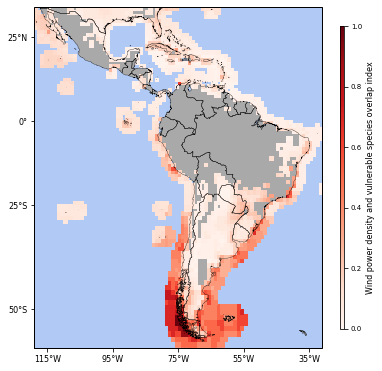

In [99]:
## Plot - Overlap bird distributions with wind potential
# Not reported in article, but useful to understand analytical workflow

position = [0.1, 0.1, 0.8, 0.8]
extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1) 

plt.close('all')
fig = plt.figure(figsize=(5,7))
ax = plt.axes(position, projection=ccrs.Mercator())
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                facecolor='cornflowerblue', zorder=2, alpha=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                facecolor='None', alpha=1, zorder=4)
# ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
#                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
ax.set_aspect('equal', 'box')
ax.outline_patch.set_zorder(15)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params('both', labelsize=fontsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
spp = ax.pcolormesh(lons, lats, superpos / np.nanmax(superpos), transform=ccrs.PlateCarree(), vmin=0,  cmap='Reds', alpha=1, zorder=3)

cax = fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(spp ,orientation='vertical', cax=cax)
cb.ax.set_ylabel('Wind power density and vulnerable species overlap index',fontsize=8)
# cb.ax.set_yticks([0,10,20,30,40,50])
cb.ax.tick_params(labelsize=7)

# nombre_salida = '/home/nicolois/wind_potential/figs/03_mapa_overlap_spp+wpd'
# fig.savefig(nombre_salida + '.png', dpi=300, bbox_inches='tight')

In [100]:
## Wind power vs present day wind turbine distribution
 
index_wpd_aerogen    = np.zeros((lenlat2,lenlon2))
index_wpd_aerogen[:] = np.nan

for ilon in range(lenlon2):
    for ilat in range(lenlat2):
        if (np.isnan(m_all[ilat,ilon]) and wpd_class[ilat,ilon] >= 1):
            index_wpd_aerogen[ilat,ilon] = wpd_class[ilat,ilon]


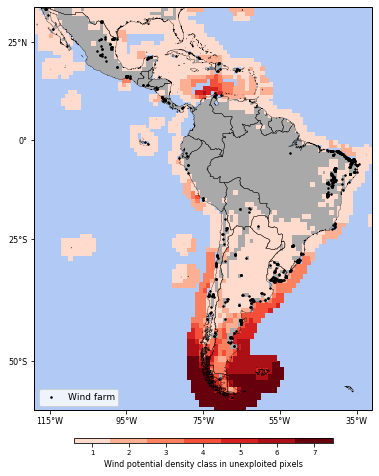

In [101]:
## Figure 5 - Wind power density where no wind energy facilities exist today

position = [0.1, 0.1, 0.8, 0.8]
extent = [-119, -31, -57.5, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1)

data_csv = '/home/nicolois/wind_potential/Eolicos_Latam_Database.csv'
data = pd.read_csv(data_csv, encoding='latin-1')
lat_farms = data['lat']
lon_farms = data['lon']

plt.close('all')
fig = plt.figure(figsize=(6,7))
ax = plt.axes(position, projection=ccrs.Mercator())
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                facecolor='cornflowerblue', zorder=2, alpha=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                facecolor='None', alpha=1, zorder=4)
# ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
#                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
ax.set_aspect('equal', 'box')
ax.outline_patch.set_zorder(15)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params('both', labelsize=fontsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
wind_superpos = ax.pcolormesh(lons2, lats2, index_wpd_aerogen, transform=ccrs.PlateCarree(),
                              vmin=0, cmap='Reds', alpha=1, zorder=3)
# wind_potential = ax.pcolormesh(lons, lats, index_wpd, transform=ccrs.PlateCarree(), vmin=0,  cmap='Reds', alpha=1, zorder=3)
ax.plot(data['lon'],data['lat'], transform=ccrs.PlateCarree(), c= 'k', lw=0, marker='.', ms=3, zorder=15, label='Wind farm')
ax.legend(loc='lower left')

# ax.plot([-95,-59,-59,-95,-95], [9,9,27,27,9], transform=ccrs.PlateCarree(), 
#          c="k", alpha=.8, lw=2, ls='solid', zorder=10, label='Caribbean')

# ax.plot([-73,-51,-51,-73,-73], [-37,-37,-37+18,-37+18,-37], transform=ccrs.PlateCarree(), 
#          c="k", alpha=.8, lw=2,ls='dashed', zorder=10, label='Center SAm')

# ax.plot([-77,-57,-57,-77,-77], [-57.15,-57.15,-43,-43,-57.15], transform=ccrs.PlateCarree(), 
#          c="k", alpha=.8, lw=2, ls='dotted', zorder=10, label='Patagonia')

ax.legend(loc='lower left',fontsize=9)
cax = fig.add_axes([0.2, 0.035, 0.6, 0.01])
cb = fig.colorbar(wind_superpos,orientation='horizontal', cax=cax,
                  boundaries=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], ticks=[1,2,3,4,5,6,7])
cb.ax.set_xlabel('Wind potential density class in unexploited pixels',fontsize=8)
cb.ax.tick_params(labelsize=7)

fig.savefig('/home/nicolois/wind_potential/figs_finales/Fig5_wpd_noFacilities.png',
            dpi=600, bbox_inches='tight')


In [109]:
# Load the csv of families into a DataFrame
df = pd.read_csv('TABLE_Birds_families.csv')
df_filtered = df[df['Species'].isin(iucn_spp)]

# Extract the columns species, order and family
species_vector = df_filtered['Species'].str.title().tolist()
order_vector = df_filtered['Order'].str.title().tolist()
family_vector = df_filtered['Family'].str.title().tolist()
vulnerability_vector = df_filtered['IUCN conservation status'].str.title().tolist()

len(df_filtered)
len (iucn_spp)


456

In [111]:
## List bird species WPD, turbines today and presence in unexploited pixels

extents = [[[-55,-43],[-77,-57]]]
[-95,-59,-59,-95,-95], [9,9,27,27,9]
result = ds_spp_iucn.where(index_wpd_aerogen > 0)
result_patagonia = result.sel(lat=slice(-55,-43),lon=slice(-77,-55))
result_centro = result.sel(lat=slice(-37,-19),lon=slice(-73,-51))
result_caribe = result.sel(lat=slice(9,27),lon=slice(-95,-59))

list_wpd_spp_aves_futuro = []
list_spp_aves_futuro = []
for i in iucn_spp:
    list_spp_aves_futuro.append(i)
    if np.nansum(result[i].values) > 0:
        list_wpd_spp_aves_futuro.append(round(np.nansum(result[i].values)/np.nansum(ds_spp_iucn[i].values),2))
        # list_wpd_spp_aves_futuro.append(round(np.nansum(index_wpd_aerogen * result[i].values)/np.nansum(result[i].values)))
        # list_wpd_spp_aves_futuro.append(round   ,2))
        # list_wpd_spp_aves_futuro.append(1)
    else:
        list_wpd_spp_aves_futuro.append(0)
        
list_turbines_spp_aves = []
list_spp_aves_futuro = []
for i in iucn_spp:
    list_spp_aves_futuro.append(i)
    if np.nansum(ds_spp_iucn[i].values) > 0:
        list_turbines_spp_aves.append(round(np.nansum(m * ds_spp_iucn[i].values)/np.nansum(ds_spp_iucn[i].values),1))
        # list_turbines_spp_aves.append(int(np.nansum(m * ds_spp_iucn[i].values)/np.nansum(ds_spp_iucn[i].values)))
    else:
        list_turbines_spp_aves.append(0)


print(list_wpd_spp_aves_futuro)
# print(result.data_vars.keys())
print((list_spp_iucn))

list_spp_patagonia = []
for i in result_patagonia.data_vars.keys():
    if np.nansum(result_patagonia[i]) > 0:
        list_spp_patagonia.append(1)
    else: 
        list_spp_patagonia.append(0)

list_spp_centro = []
for i in result_centro.data_vars.keys():
    if np.nansum(result_centro[i]) > 0:
        list_spp_centro.append(1)
    else: 
        list_spp_centro.append(0)        

list_spp_caribe = []
for i in result_centro.data_vars.keys():
    if np.nansum(result_caribe[i]) > 0:
        list_spp_caribe.append(1)
    else: 
        list_spp_caribe.append(0)   
        

df = pd.DataFrame({'Species': list_spp_aves_futuro, 'Order': order_vector, 'Family': family_vector, 'IUCN conservation status': vulnerability_vector,
                   'Turbines density in whole distribution (per pixel ~ 10k km2)': list_turbines_spp_aves,
                   'WPD>1 with no turbines today (percent of distribution)': list_wpd_spp_aves_futuro})

df.to_csv("/home/nicolois/wind_potential/TableS4_spp_aves_overlaps.csv", index=False)

df



/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


[0.9, 0, 0.33, 0.5, 0, 1.0, 0.2, 0.82, 0.29, 0, 0, 0.67, 0, 1.0, 1.0, 0.21, 1.0, 0, 1.0, 1.0, 0, 0.24, 0.78, 0.33, 0.1, 0.5, 1.0, 0.48, 0.56, 0.5, 0.83, 0.17, 0.06, 0.83, 0.12, 0.25, 0, 0.33, 0.52, 0.49, 0, 0.5, 0.22, 0, 1.0, 1.0, 0.05, 0.1, 0.07, 0, 0.04, 0.1, 0.89, 0.34, 0, 1.0, 0, 0, 0, 0, 0.53, 0, 0, 0, 1.0, 0, 0.31, 0, 0.08, 0.62, 0.46, 0.92, 0.44, 0.31, 0.42, 0.2, 0, 0.01, 0.85, 0, 0, 0.33, 1.0, 0.61, 0.67, 0.04, 0.48, 0, 0.05, 0.2, 0.67, 0, 0.32, 0.34, 0, 0.89, 0.43, 0.04, 0, 0.31, 0, 0.6, 0, 0, 0, 0, 1.0, 0.22, 0, 0, 0, 0.89, 0.3, 0, 0, 0, 0.52, 0.29, 0.39, 0, 0, 0.13, 0.31, 0.21, 0.02, 0.13, 0.18, 0.31, 1.0, 0, 0.36, 0, 0, 0, 0, 0.06, 0, 1.0, 0.05, 0.14, 0.2, 0, 0.5, 0, 0.28, 1.0, 0, 0.5, 0.6, 0.31, 0, 0, 0, 0, 0.25, 0.86, 0, 0.11, 1.0, 0.5, 0, 0, 0, 0.18, 1.0, 1.0, 0.5, 1.0, 1.0, 0.57, 0, 0.7, 0, 0.89, 0, 0, 0, 0, 0.47, 0, 0, 0.07, 0, 0, 0, 0, 0, 1.0, 0, 0.84, 0, 0.82, 0.12, 0.32, 0, 0.09, 0.27, 0.4, 0, 0, 0.27, 0.44, 0.51, 0.19, 0.77, 0.19, 0.83, 0.3, 1.0, 0, 0, 0, 0, 1.0, 1

,Species,Order,Family,IUCN conservation status,Turbines density in whole distribution (per pixel ~ 10k km2),WPD>1 with no turbines today (percent of distribution)
0,Accipiter gundlachi,Accipitriformes,Accipitridae,Endangered,2.3,0.90
1,Acrobatornis fonsecai,Passeriformes,Furnariidae,Vulnerable,0.0,0.00
2,Agelaius tricolor,Passeriformes,Icteridae,Endangered,8.7,0.33
3,Agelaius xanthomus,Passeriformes,Icteridae,Endangered,10.3,0.50
4,Aglaeactis aliciae,Caprimulgiformes,Trochilidae,Vulnerable,0.0,0.00
...,...,...,...,...,...,...
451,Xipholena atropurpurea,Passeriformes,Cotingidae,Vulnerable,14.3,0.41
452,Xolmis dominicanus,Passeriformes,Tyrannidae,Vulnerable,20.2,0.64
453,Zaratornis stresemanni,Passeriformes,Cotingidae,Vulnerable,0.0,0.18
454,Zentrygon carrikeri,Columbiformes,Columbidae,Endangered,0.0,1.00


In [115]:
## List bat species WPD, turbines today and presence in unexploited pixels

result = ds_spp_murcis.where(index_wpd_aerogen > 0)
# print (result)

list_wpd_spp_murcis_futuro = []
list_spp_murcis_futuro = []
for i in result.data_vars.keys():
    list_spp_murcis_futuro.append(i)
    if np.nansum(result[i].values) > 0:
        list_wpd_spp_murcis_futuro.append(round(np.nansum(index_wpd_aerogen * result[i].values)/np.nansum(result[i].values),2))
        # list_wpd_spp_murcis_futuro.append(1)
    else:
        list_wpd_spp_murcis_futuro.append(0)

        
list_turbines_spp_murcis = []
list_spp_murcis_futuro = []
for i in ds_spp_murcis.data_vars.keys():
    list_spp_murcis_futuro.append(i)
    if np.nansum(ds_spp_murcis[i].values) > 0:
        list_turbines_spp_murcis.append(round(np.nansum(m * ds_spp_murcis[i].values)/np.nansum(ds_spp_murcis[i].values),1))
    else:
        list_turbines_spp_murcis.append(0)

result_patagonia = result.sel(lat=slice(-55,-43),lon=slice(-77,-55))
result_centro = result.sel(lat=slice(-37,-19),lon=slice(-73,-51))
result_caribe = result.sel(lat=slice(9,27),lon=slice(-95,-59))

list_spp_patagonia = []
for i in result_patagonia.data_vars.keys():
    if np.nansum(result_patagonia[i]) > 0:
        list_spp_patagonia.append(1)
    else: 
        list_spp_patagonia.append(0)

list_spp_centro = []
for i in result_centro.data_vars.keys():
    if np.nansum(result_centro[i]) > 0:
        list_spp_centro.append(1)
    else: 
        list_spp_centro.append(0)        

list_spp_caribe = []
for i in result_centro.data_vars.keys():
    if np.nansum(result_caribe[i]) > 0:
        list_spp_caribe.append(1)
    else: 
        list_spp_caribe.append(0)   
        
print(list_spp_murcis_futuro)
print(list_spp_patagonia)
print(list_spp_centro)
print(list_spp_caribe)

df = pd.DataFrame({'Species': list_spp_murcis, 'Turbine density': list_turbines_spp_murcis,
                   'WPD-NoTurbine density': list_wpd_spp_murcis_futuro})#, 'Patagonia': list_spp_patagonia,
#                   'Center SAm': list_spp_centro, 'Caribbean': list_spp_caribe})

df.to_csv("/home/nicolois/wind_potential/TableS4_spp_bats_overlaps.csv", index=False)
df


['Tomopeas ravus', 'Saccopteryx antioquensis', 'Lasiurus minor', 'Pteronotus paraguanensis', 'Rhogeessa genowaysi', 'Rhogeessa mira', 'Rhogeessa minutilla', 'Balantiopteryx io', 'Natalus primus', 'Lasiurus insularis', 'Lonchophylla dekeyseri', 'Lonchophylla bokermanni', 'Lonchorhina marinkellei', 'Lonchorhina fernandezi', 'Chilonatalus micropus', 'Choeroniscus periosus', 'Sturnira nana', 'Myotis atacamensis', 'Vampyressa melissa', 'Myotis findleyi', 'Myotis peninsularis', 'Myotis planiceps', 'Myotis vivesi', 'Amorphochilus schnablii', 'Mormopterus minutus', 'Mormopterus phrudus', 'Musonycteris harrisoni', 'Molossops aequatorianus', 'Perimyotis subflavus', 'Leptonycteris nivalis', 'Leptonycteris curasoae', 'Balantiopteryx infusca', 'Platyrrhinus chocoensis', 'Lonchorhina orinocensis']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


,Species,Turbine density,WPD-NoTurbine density
0,Tomopeas ravus,3.0,1.22
1,Saccopteryx antioquensis,0.0,0.00
2,Lasiurus minor,11.0,1.20
3,Pteronotus paraguanensis,38.0,2.00
4,Rhogeessa genowaysi,0.0,0.00
5,Rhogeessa mira,0.0,0.00
6,Rhogeessa minutilla,1.3,1.39
7,Balantiopteryx io,52.8,1.00
8,Natalus primus,0.0,1.00
9,Lasiurus insularis,2.4,1.04


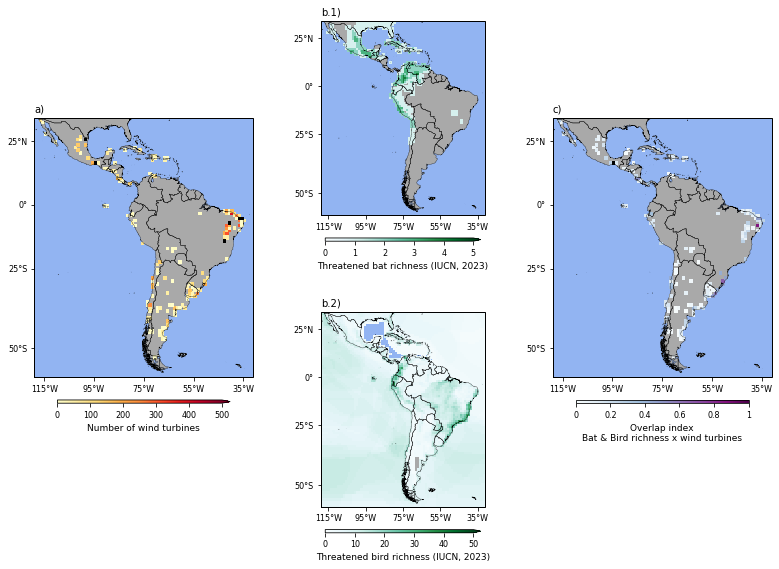

In [ ]:
## Map of overlap between wind turbines and birds and bats.

position = [[0.05, 0.3, 0.3, 0.4],
            [0.4, 0.1, 0.2, 0.3], [0.4, 0.55, 0.2, 0.3], 
            [0.65, 0.3, 0.3, 0.4]]

cb_axes =  [[0.1, 0.26, 0.2, 0.005],
            [0.41, 0.06, 0.18, 0.005], [0.41, 0.51, 0.18, 0.005], 
            [0.7, 0.26, 0.2, 0.005]]

extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1)

plt.close('all')
fig = plt.figure(figsize=(12,9))

for i in range(len(position)):
    ax = plt.axes(position[i], projection=ccrs.Mercator())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                    facecolor='cornflowerblue', zorder=2, alpha=0.7)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                    facecolor='None', alpha=1, zorder=4)
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
    #                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
    ax.set_aspect('equal', 'box')
    ax.outline_patch.set_zorder(15)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params('both', labelsize=fontsize)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    # ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)

    if i == 0:
        spp = ax.pcolormesh(lons, lats, m, transform=ccrs.PlateCarree(), vmin=0, vmax=500,
                            cmap='YlOrRd', alpha=1, zorder=3)
        ax.pcolormesh(lons,lats, windfarm95, transform=ccrs.PlateCarree(), vmin=0, vmax=1,
                        cmap='Greys', alpha=1, zorder=7)

        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
        cb.ax.set_xlabel('Number of wind turbines',fontsize=9)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('a)', loc='left', fontsize=10)
        
    if i == 1:
        spp = ax.pcolormesh(lons, lats, mapa_cant_spp_iucn, transform=ccrs.PlateCarree(),
                            vmin=0, vmax=50, cmap='BuGn', alpha=1, zorder=3)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
        cb.ax.set_xlabel('Threatened bird richness (IUCN, 2023)',fontsize=9)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('b.2)', loc='left', fontsize=10)

    if i == 2:
        spp = ax.pcolormesh(lons, lats, mapa_cant_spp_murcis, transform=ccrs.PlateCarree(),
                            vmin=0, vmax=5, cmap='BuGn', alpha=1, zorder=3)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
        cb.ax.set_xlabel('Threatened bat richness (IUCN, 2023)',fontsize=9)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('b.1)', loc='left', fontsize=10)
                        
    if i == 3:
        spp = ax.pcolormesh(lons, lats, superpos_spp_aerogen/np.nanmax(superpos_spp_aerogen),
                            vmin=-0, vmax=1, transform=ccrs.PlateCarree(),
                            cmap='BuPu', alpha=1, zorder=3)
        ax.pcolormesh(lons,lats, superpos95,transform=ccrs.PlateCarree(),
                        vmin=0, vmax=1, cmap='Greys', alpha=1, zorder=7)
        spp = ax.pcolormesh(lons, lats, superpos_spp_aerogen_iucn/np.nanmax(superpos_spp_aerogen_iucn),
                            vmin=-0, vmax=1, transform=ccrs.PlateCarree(),
                            cmap='BuPu', alpha=1, zorder=3)
        ax.pcolormesh(lons,lats, superpos95_iucn,transform=ccrs.PlateCarree(),
                        vmin=0, vmax=1, cmap='Greys', alpha=1, zorder=7)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, ticks=[0,.2,.4,.6,.8,1])
        cb.ax.set_xlim([0,1])
        cb.ax.set_xlabel('Overlap index\nBat & Bird richness x wind turbines',fontsize=9)
        cb.ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'], fontsize=8)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('c)', loc='left', fontsize=10)



# nombre_salida = '/home/nicolois/wind_potential/figs/12_plot_birds&bats'
# fig.savefig(nombre_salida + '.png', dpi=300, bbox_inches='tight')

In [ ]:
## Que especies más vulnerables??
        
list_spp_hoy = []
list_spp_hoy_95 = []
result = ds_spp_iucn.where((index_m_superpos > .95))
for i in result.data_vars.keys():
    list_spp_hoy.append(i)
    if np.nansum(result[i]) >= 1:
        list_spp_hoy_95.append(1)
    else:
        list_spp_hoy_95.append(0)

result = ds_spp_murcis.where((index_m_superpos > .95))
for i in result.data_vars.keys():
    list_spp_hoy.append(i)
    if np.nansum(result[i]) >= 1:
        list_spp_hoy_95.append(1)
    else:
        list_spp_hoy_95.append(0)

print(list_spp_hoy_95)
print(len(list_spp_hoy_95))

df = pd.DataFrame({'Species': list_spp_hoy, 'Within 95th percentile of wind turbines': list_spp_hoy_95})
df.drop_duplicates(inplace=True)
print(df.size)
df.to_csv('/home/nicolois/wind_potential/lists_spp_hoy_95.csv', index=False)

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

/home/nicolois/envs/vulnenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [ ]:
## Overlap spp con wind potential donde aún no hay aerogeneradores.

index_spp_wpd_aerogen = index_wpd_aerogen * index_cant_spp_iucn
index_spp_wpd_aerogen = index_spp_wpd_aerogen / np.nanmax(index_spp_wpd_aerogen)

index_bat_spp_wpd_aerogen = index_wpd_aerogen * index_cant_spp_murcis
index_bat_spp_wpd_aerogen = index_bat_spp_wpd_aerogen / np.nanmax(index_bat_spp_wpd_aerogen)



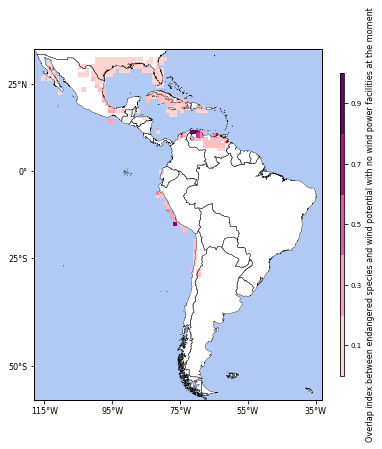

In [ ]:
# fig 2: overlap spp con wind potential donde aún no hay aerogeneradores
 
position = [0.1, 0.1, 0.8, 0.8]
extent = [-118, -33, -56, 34]
xticks = [-115, -95, -75, -55, -35]
yticks = [-55, -45, -35, -25, -15, -5, 5, 15, 25]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1)

plt.close('all')
fig = plt.figure(figsize=(5,7))
ax = plt.axes(position, projection=ccrs.Mercator())
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='white', zorder=2)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05, facecolor='cornflowerblue', zorder=2, alpha=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3, facecolor='None', alpha=1, zorder=4)
# ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
#                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
ax.set_aspect('equal', 'box')
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params('both', labelsize=fontsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
# wind_superpos = ax.pcolormesh(lons, lats-1, index_spp_wpd_aerogen, transform=ccrs.PlateCarree(),
                            #   vmin=-.1, cmap='RdPu', alpha=1, zorder=3)
wind_superpos = ax.pcolormesh(lons, lats-1, index_bat_spp_wpd_aerogen, transform=ccrs.PlateCarree(),
                              vmin=-.1, cmap='RdPu', alpha=1, zorder=3)

# wind_potential = ax.pcolormesh(lons, lats, index_wpd, transform=ccrs.PlateCarree(), vmin=0,  cmap='Reds', alpha=1, zorder=3)


cax = fig.add_axes([0.95, 0.2, 0.01, 0.6])
cb = fig.colorbar(wind_superpos,orientation='vertical', cax=cax,
                boundaries=[0,.2,.4,.6,.8,1], ticks=[.1,.3,.5,.7,.9])
cb.ax.set_ylabel('Overlap index between endangered species and wind potential with no wind power facilities at the moment',fontsize=8)
cb.ax.tick_params(labelsize=7)

fig.savefig('/home/nicolois/wind_potential/figs/08_mapa_spp_wpd_yetNoFacilities.png', dpi=300, bbox_inches='tight')

In [117]:
## Sensibilidad del análisis por las diferentes variables

index_iucn_aerogen = index_cant_spp_iucn * index_m_superpos
index_iucn_aerogen = index_iucn_aerogen / np.nanmax(index_iucn_aerogen)

index_iucn_facilit = index_cant_spp_iucn * index_m_all_superpos
index_iucn_facilit = index_iucn_facilit / np.nanmax(index_iucn_facilit)

index_ebir_aerogen = index_cant_spp_ebird * index_m_superpos
index_ebir_aerogen = index_ebir_aerogen / np.nanmax(index_ebir_aerogen)

index_ebir_facilit = index_cant_spp_ebird * index_m_all_superpos
index_ebir_facilit = index_ebir_facilit / np.nanmax(index_ebir_facilit)

diff_iucn_ebird      = index_iucn_aerogen - index_ebir_aerogen
diff_aergoen_facilit = index_iucn_aerogen - index_iucn_facilit


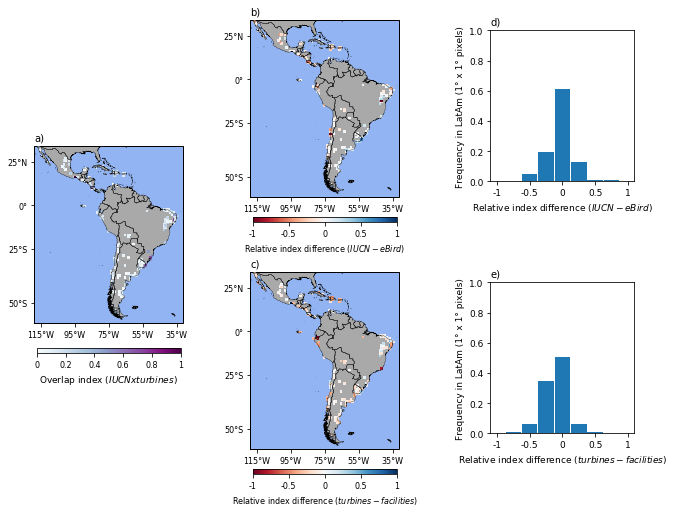

In [118]:
## Plot Aerogeneradores + IUCN

position = [[0.05, 0.35, 0.3, 0.35], [0.35, 0.6, 0.3, 0.35], [0.73, 0.63, 0.2, 0.3],
                                    [0.35, 0.1, 0.3, 0.35], [0.73, 0.13, 0.2, 0.3],]

cb_axes =  [[0.1, 0.29, 0.2, 0.01], [0.4, 0.55, 0.2, 0.01],  [],
                                     [0.4, 0.05, 0.2, 0.01],  []]

extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1)

plt.close('all')
fig = plt.figure(figsize=(10,7))

for i in range(len(position)):
    if (i == 2 or i == 4):
        ax = plt.axes(position[i])
        ax.set_ylim([0,1])
        ax.set_xlim([-1.1,1.1])
        ax.set_xticks([-1,-.5,0,.5,1])
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
            
        if i == 2:
            dim1 = np.reshape(diff_iucn_ebird/np.nanmax(abs(diff_iucn_ebird)),-1)
            bins = [-.875,-.625,-.375,-.125,.125,.375,.625,.875]

            # Calcular el histograma
            counts, bin_edges = np.histogram(dim1, bins=bins)

            # Calcular las frecuencias relativas
            frequencies_relative = counts / counts.sum()

            ax.hist(bin_edges[:-1], bins, weights=frequencies_relative, rwidth=0.95)
            ax.tick_params('both', labelsize=9)
            ax.set_xlabel('Relative index difference ' + r'$(IUCN - eBird)$', fontsize=9)
            ax.set_ylabel('Frequency in LatAm (1° x 1° pixels)', fontsize=9)
            ax.set_title('d)', loc='left', fontsize=10)
        
        if i == 4:
            dim1 = np.reshape(diff_aergoen_facilit/np.nanmax(abs(diff_aergoen_facilit)),-1)
            bins = [-.875,-.625,-.375,-.125,.125,.375,.625,.875]
            # Calcular el histograma
            counts, bin_edges = np.histogram(dim1, bins=bins)
            # Calcular las frecuencias relativas
            frequencies_relative = counts / counts.sum()
            ax.hist(bin_edges[:-1], bins, weights=frequencies_relative, rwidth=0.95)
            ax.tick_params('both', labelsize=9)
            ax.set_xlabel('Relative index difference ' + r'$(turbines - facilities)$',fontsize=9)
            ax.set_ylabel('Frequency in LatAm (1° x 1° pixels)', fontsize=9)
            ax.set_title('e)', loc='left', fontsize=10)

            
    else:
        ax = plt.axes(position[i], projection=ccrs.Mercator())
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                       facecolor='cornflowerblue', zorder=2, alpha=0.7)
        ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                       facecolor='None', alpha=1, zorder=4)
        # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
        #                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
        ax.set_aspect('equal', 'box')
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.tick_params('both', labelsize=fontsize)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        # ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)
        
        if i == 0:
            spp = ax.pcolormesh(lons, lats, index_iucn_aerogen, transform=ccrs.PlateCarree(),
                                vmin=0, vmax=1, cmap='BuPu', alpha=1, zorder=3)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, ticks=[0,.2,.4,.6,.8,1])
            cb.ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'], fontsize=8)
            cb.ax.set_xlabel('Overlap index ' + r'$(IUCN x turbines)$',fontsize=9)
            cb.ax.tick_params(labelsize=8)
            ax.set_title('a)', loc='left', fontsize=10)
            
        if i == 1:
            spp = ax.pcolormesh(lons, lats, diff_iucn_ebird/np.nanmax(abs(diff_iucn_ebird)), transform=ccrs.PlateCarree(), 
                                vmin=-1, vmax=1, cmap='RdBu', alpha=1, zorder=3)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, ticks=[-1,-0.5,0,0.5,1])
            cb.ax.set_xlabel('Relative index difference ' + r'$(IUCN - eBird)$',fontsize=8)
            cb.ax.set_xticklabels(['-1','-0.5','0','0.5','1'], fontsize=8)
            cb.ax.tick_params(labelsize=8)
            ax.set_title('b)', loc='left', fontsize=10)
                    
        if i == 3:
            spp = ax.pcolormesh(lons, lats, diff_aergoen_facilit/np.nanmax(abs(diff_aergoen_facilit)), transform=ccrs.PlateCarree(),
                                vmin=-1, vmax=1, cmap='RdBu', alpha=1, zorder=3)
            cax = fig.add_axes(cb_axes[i])
            cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, ticks=[-1,-0.5,0,0.5,1])
            cb.ax.set_xlabel('Relative index difference ' + r'$(turbines - facilities)$',fontsize=8)
            cb.ax.set_xticklabels(['-1','-0.5','0','0.5','1'], fontsize=8)
            cb.ax.tick_params(labelsize=8)
            ax.set_title('c)', loc='left', fontsize=10)
        


nombre_salida = '/home/nicolois/wind_potential/figs_finales/FigS2_Sensibilidad'
fig.savefig(nombre_salida + '.png', dpi=300, bbox_inches='tight')

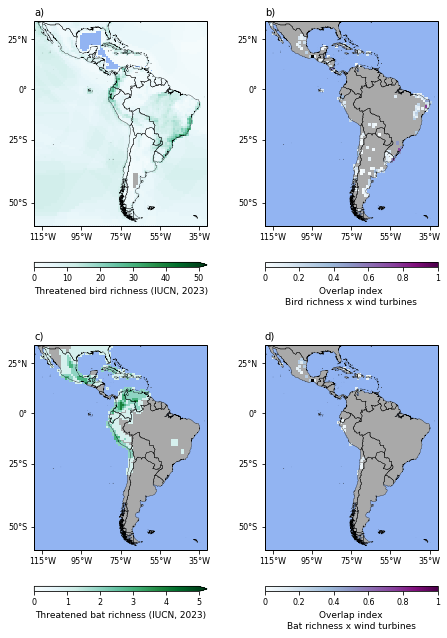

In [119]:
## Nueva versión overlap Turbines + threatened richness
## Plot Aerogeneradores + IUCN

position = [[0.2, 0.55, 0.3, 0.4], [0.6, 0.55, 0.3, 0.4], 
            [0.2, 0.1, 0.3, 0.4], [0.6, 0.1, 0.3, 0.4]]

cb_axes =  [[0.2, 0.55, 0.3, 0.007], [0.6, 0.55, 0.3, 0.007], 
            [0.2, 0.1, 0.3, 0.007], [0.6, 0.1, 0.3, 0.007]]

extent = [-119, -31, -57, 33]
xticks = [-115, -95, -75, -55, -35]
yticks = [-50, -25, 0, 25]
fontsize = 8

lons = np.arange(-120,-30,1)
lats = np.arange(-58,34,1)

plt.close('all')
fig = plt.figure(figsize=(8,10))

for i in range(len(position)):
    ax = plt.axes(position[i], projection=ccrs.Mercator())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, lw=0.15, zorder=4)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), facecolor='darkgray', zorder=2)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m'), edgecolor='k', lw=0.05,
                    facecolor='cornflowerblue', zorder=2, alpha=0.7)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), edgecolor='k', lw=0.3,
                    facecolor='None', alpha=1, zorder=4)
    # ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m'), edgecolor='k',
    #                                    facecolor=cfeature.COLORS['land'], lw=0.2, alpha=0.5, zorder=10)
    ax.set_aspect('equal', 'box')
    ax.outline_patch.set_zorder(15)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params('both', labelsize=fontsize)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    # ax.set_title('Especies de aves amenazadas en Sudamerica', loc="left", fontsize=8)

    if i == 0:
        spp = ax.pcolormesh(lons, lats, mapa_cant_spp_iucn, transform=ccrs.PlateCarree(),
                            vmin=0, vmax=50, cmap='BuGn', alpha=1, zorder=3)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
        cb.ax.set_xlabel('Threatened bird richness (IUCN, 2023)',fontsize=9)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('a)', loc='left', fontsize=10)

    if i == 1:
        spp = ax.pcolormesh(lons, lats, superpos_spp_aerogen_iucn/np.nanmax(superpos_spp_aerogen_iucn),
                            vmin=-0, vmax=1, transform=ccrs.PlateCarree(),
                            cmap='BuPu', alpha=1, zorder=3)
        ax.pcolormesh(lons,lats, superpos95_iucn,transform=ccrs.PlateCarree(),
                        vmin=0, vmax=1, cmap='Greys', alpha=1, zorder=7)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, ticks=[0,.2,.4,.6,.8,1])
        cb.ax.set_xlim([0,1])
        cb.ax.set_xlabel('Overlap index\nBird richness x wind turbines',fontsize=9)
        cb.ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'], fontsize=8)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('b)', loc='left', fontsize=10)
        
        
    if i == 2:
        spp = ax.pcolormesh(lons, lats, mapa_cant_spp_murcis, transform=ccrs.PlateCarree(),
                            vmin=0, vmax=5, cmap='BuGn', alpha=1, zorder=3)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, extend='max')
        cb.ax.set_xlabel('Threatened bat richness (IUCN, 2023)',fontsize=9)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('c)', loc='left', fontsize=10)
                        

    if i == 3:
        spp = ax.pcolormesh(lons, lats, superpos_spp_aerogen/np.nanmax(superpos_spp_aerogen),
                            vmin=-0, vmax=1, transform=ccrs.PlateCarree(),
                            cmap='BuPu', alpha=1, zorder=3)
        ax.pcolormesh(lons,lats, superpos95,transform=ccrs.PlateCarree(),
                        vmin=0, vmax=1, cmap='Greys', alpha=1, zorder=7)
        cax = fig.add_axes(cb_axes[i])
        cb = fig.colorbar(spp ,orientation='horizontal', cax=cax, ticks=[0,.2,.4,.6,.8,1])
        cb.ax.set_xlim([0,1])
        cb.ax.set_xlabel('Overlap index\nBat richness x wind turbines',fontsize=9)
        cb.ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'], fontsize=8)
        cb.ax.tick_params(labelsize=8)
        ax.set_title('d)', loc='left', fontsize=10)

nombre_salida = '/home/nicolois/wind_potential/figs_finales/Fig4_BirdsBats_OverlapIndex'
fig.savefig(nombre_salida + '.png', dpi=300, bbox_inches='tight')